# Create a model using DistilBERT trained on route data

In [35]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import tensorflow as tf

import pandas as pd
import numpy as np

classifier = pipeline('sentiment-analysis')

In [36]:
import random
random.seed(42)

In [37]:
save_directory = "models/route_model"

In [38]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=False, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])

All model checkpoint weights were used when initializing TFDistilBertModel.

All the weights of TFDistilBertModel were initialized from the model checkpoint at models/route_model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [39]:
df = pd.read_csv('data/labeled_forum_test.csv')
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.20, random_state=42)

In [40]:
# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

In [41]:
# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [42]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=30, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/30
2591/2591 [==============================] - 152s 59ms/sample - loss: 0.7984 - acc: 0.7156 - val_loss: 0.7176 - val_acc: 0.7500
Epoch 2/30
2591/2591 [==============================] - 145s 56ms/sample - loss: 0.7056 - acc: 0.7495 - val_loss: 0.6777 - val_acc: 0.7500
Epoch 3/30
2591/2591 [==============================] - 141s 54ms/sample - loss: 0.6560 - acc: 0.7495 - val_loss: 0.6181 - val_acc: 0.7500
Epoch 4/30
2591/2591 [==============================] - 141s 55ms/sample - loss: 0.6062 - acc: 0.7491 - val_loss: 0.5817 - val_acc: 0.7500
Epoch 5/30
2591/2591 [==============================] - 142s 55ms/sample - loss: 0.5819 - acc: 0.7541 - val_loss: 0.5514 - val_acc: 0.7747
Epoch 6/30
2591/2591 [==============================] - 141s 55ms/sample - loss: 0.5407 - acc: 0.7800 - val_loss: 0.5584 - val_acc: 0.7963
Epoch 7/30
2591/2591 [==============================] - 144s 56ms/sample - loss: 0.5191 - acc: 0.7850 - val_loss: 0.530

In [43]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

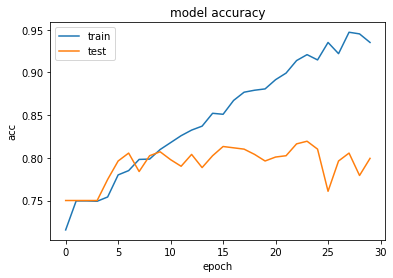

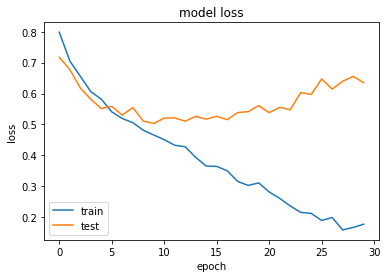

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

In [46]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)

810/810 [==============================] - 51s 63ms/sample - loss: 0.5979 - acc: 0.8160


In [47]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5978713023809739
Test Accuracy: 0.8160494


In [49]:
model.save_weights('models/final_models/route_only/route_only')

## best epoch is 10:
loss: 0.4657 - acc: 0.8097 - val_loss: 0.5030 - val_acc: 0.8071

In [50]:
history = model.fit([X_train["input_ids"], X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=10, 
          verbose=1, 
          validation_split=0.2)

Train on 2591 samples, validate on 648 samples
Epoch 1/10
2591/2591 [==============================] - 138s 53ms/sample - loss: 0.1425 - acc: 0.9475 - val_loss: 0.6693 - val_acc: 0.7840
Epoch 2/10
2591/2591 [==============================] - 139s 54ms/sample - loss: 0.1242 - acc: 0.9556 - val_loss: 0.7387 - val_acc: 0.7639
Epoch 3/10
2591/2591 [==============================] - 143s 55ms/sample - loss: 0.1181 - acc: 0.9610 - val_loss: 0.7289 - val_acc: 0.7670
Epoch 4/10
2591/2591 [==============================] - 146s 56ms/sample - loss: 0.1203 - acc: 0.9568 - val_loss: 0.6896 - val_acc: 0.8009
Epoch 5/10
2591/2591 [==============================] - 177s 68ms/sample - loss: 0.1093 - acc: 0.9626 - val_loss: 0.7271 - val_acc: 0.7824
Epoch 6/10
2591/2591 [==============================] - 241s 93ms/sample - loss: 0.0992 - acc: 0.9660 - val_loss: 0.7526 - val_acc: 0.7948
Epoch 7/10
2591/2591 [==============================] - 242s 94ms/sample - loss: 0.0815 - acc: 0.9722 - val_loss: 0.759

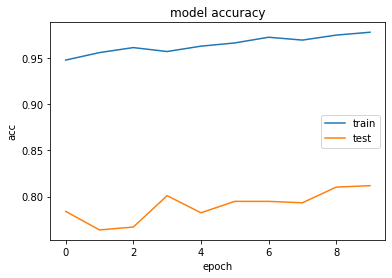

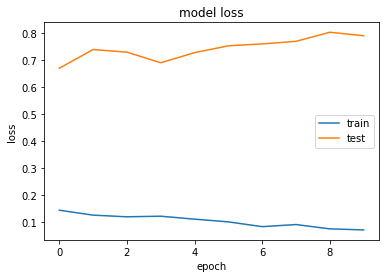

In [51]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='center right')
plt.show()

In [52]:
score = model.evaluate([X_test["input_ids"], X_test["attention_mask"]], y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

810/810 [==============================] - 54s 66ms/sample - loss: 0.7482 - acc: 0.8136
Test Score: 0.748170049396562
Test Accuracy: 0.8135803


In [53]:
model.save_weights('models/final_models/route_only2/route_only2')